In [130]:
import helpFunctions as hf 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread
import pandas as pd

In [131]:
dirIn = 'data/'
multiIm, annotationIm = hf.loadMulti('multispectral_day01.mat' , 'annotation_day01.png', dirIn)
[salamiPix, salamiR, salamiC] = hf.getPix(multiIm, annotationIm[:,:,0])
[fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1])
[meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2])

In [133]:
def train_thr_model(fatPix, meatPix):
    Nf, Nm = fatPix.shape[0], meatPix.shape[0]
    err = np.zeros(19)
    thr = np.zeros(19)

    for l in range(19):
        mu_f = np.mean(fatPix[:, l])
        mu_m = np.mean(meatPix[:, l])
        thr[l] = 0.5 * (mu_f + mu_m)

        fat_wrong  = np.sum(fatPix[:, l]  <  thr[l])
        meat_wrong = np.sum(meatPix[:, l] >= thr[l])
        err[l] = (fat_wrong + meat_wrong) / (Nf + Nm)

    best_l = int(np.argmin(err))
    best_band = best_l + 1
    thr_best = thr[best_l]
    return best_l, best_band, thr_best

def eval_thr_model(fatPix, meatPix, best_l, thr_best):
    Nf, Nm = fatPix.shape[0], meatPix.shape[0]
    fat_wrong  = np.sum(fatPix[:, best_l]  <  thr_best)
    meat_wrong = np.sum(meatPix[:, best_l] >= thr_best)
    return (fat_wrong + meat_wrong) / (Nf + Nm)

best_l, best_band, thr_best = train_thr_model(fatPix, meatPix)
err_best = eval_thr_model(fatPix, meatPix, best_l, thr_best)

best_band, thr_best, err_best


(14, np.float64(68.9655142758858), np.float64(0.00463768115942029))

In [134]:
def train_lda(fatPix, meatPix):
    #Number of annotated fat and meat pixels
    Nf = fatPix.shape[0]
    Nm = meatPix.shape[0]

    # Means 
    mu_f = np.mean(fatPix, axis=0)
    mu_m = np.mean(meatPix, axis=0)

    # Covariance matrices for fat and meat
    Sigma_f = np.cov(fatPix, rowvar=False, ddof=1)
    Sigma_m = np.cov(meatPix, rowvar=False, ddof=1)
    # Pooled covariance (LDA assumption)
    Sigma = ((Nf-1)*Sigma_f + (Nm-1)*Sigma_m) / ((Nf-1)+(Nm-1))
    Sigma_inv = np.linalg.pinv(Sigma)
    # rewrite (S_f - S_m) to x^T*w+c
    w = Sigma_inv @ (mu_f - mu_m)
    c = -0.5 * (mu_f @ Sigma_inv @ mu_f - mu_m @ Sigma_inv @ mu_m)
    return Sigma, w, c

def eval_lda(fatPix, meatPix, w, c):
    Nf, Nm = fatPix.shape[0], meatPix.shape[0]
    fat_wrong  = np.sum((fatPix  @ w + c) < 0)
    meat_wrong = np.sum((meatPix @ w + c) >= 0)
    return (fat_wrong + meat_wrong) / (Nf + Nm)

In [135]:
# helper for loading days
def load_day(d):
    ms_file = f"multispectral_day{d:02d}.mat"
    an_file = f"annotation_day{d:02d}.png"
    return hf.loadMulti(ms_file, an_file, dirIn)

In [136]:
# fat proportion helper function
def proportion(clss):
    n_meat = len(clss[clss == 1])
    n_fat = len(clss[clss == 2])
    return n_fat / (n_fat + n_meat)

In [137]:
days = [1, 6, 13, 20, 28]
n = len(days)


results_all_days = []

classifications = {day:{} for day in days}
# trains models for each day and tests on remaining
for i, d_train in enumerate(days):
    #load data
    multi_train, ann_train = load_day(d_train)
    fat_train, _, _  = hf.getPix(multi_train, ann_train[:, :, 1])
    meat_train, _, _ = hf.getPix(multi_train, ann_train[:, :, 2])

    # train both models on this day
    best_l, _, thr_best = train_thr_model(fat_train, meat_train)
    _, w, c = train_lda(fat_train, meat_train)
    pf=0.3
    pm=0.7
    log_prior=np.log(pf) - np.log(pm)
    c_w_prior_d = c + log_prior

    # test on other days
    for j, d_test in enumerate(days):
        if d_test == d_train:
            continue

        multi_test, ann_test = load_day(d_test)
        fat_test, _, _  = hf.getPix(multi_test, ann_test[:, :, 1])
        meat_test, _, _ = hf.getPix(multi_test, ann_test[:, :, 2])

        thr_err = eval_thr_model(fat_test, meat_test, best_l, thr_best)
        lda_err = eval_lda(fat_test, meat_test, w, c)
        lda_w_prior_err = eval_lda(fat_test, meat_test, w, c_w_prior_d)

        # saving classifications in dict
        salami_an_test = (ann_test[:,:,0] | ann_test[:,:,1] | ann_test[:,:,2]).astype(bool)
        X_salami = multi_test[salami_an_test, :].astype(np.float64)
        s_salami = X_salami @ w + c
        s_salami_w_prior = X_salami @ w + c_w_prior_d

        cls_thr = np.zeros(multi_test.shape[:2], dtype=np.uint8)
        cls_lda = np.zeros(multi_test.shape[:2], dtype=np.uint8)
        cls_lda_prior = np.zeros(multi_test.shape[:2], dtype=np.uint8)

        cls_thr[salami_an_test] = 1
        cls_thr[salami_an_test & (multi_test[:, :, best_l] >= thr_best)] = 2
        cls_lda[salami_an_test] = np.where(s_salami >= 0, 2, 1)
        cls_lda_prior[salami_an_test] = np.where(s_salami_w_prior >= 0, 2, 1)

        results_all_days.append({"train": d_train,
                                 "test": d_test,
                                 "thr err": thr_err,
                                 "lda err": lda_err,
                                 "lda prior err": lda_w_prior_err,
                                 "thr prop": proportion(cls_thr),
                                 "LDA prop": proportion(cls_lda),
                                 "LDA prior prop": proportion(cls_lda_prior),})

        classifications[d_train].update({d_test :  { "training_day" : d_train,
                                "testing_day" : d_test,
                                "thr":cls_thr,
                               "multi-lda":cls_lda,
                               "lda_prior":cls_lda_prior}})


# Print
df = pd.DataFrame(results_all_days)
print(df.to_string(index=False))


 train  test  thr err  lda err  lda prior err  thr prop  LDA prop  LDA prior prop
     1     6 0.123195 0.021174       0.021655  0.294006  0.203496        0.195318
     1    13 0.123724 0.085886       0.087688  0.091858  0.075008        0.071106
     1    20 0.241765 0.138824       0.140000  0.171606  0.140278        0.134528
     1    28 0.182432 0.059846       0.063224  0.308673  0.179196        0.169870
     6     1 0.010435 0.023188       0.024348  0.136384  0.093476        0.090689
     6    13 0.077477 0.015616       0.016817  0.080301  0.093099        0.089869
     6    20 0.152353 0.042353       0.045882  0.091654  0.109726        0.105220
     6    28 0.121622 0.042471       0.045367  0.087373  0.151340        0.146448
    13     1 0.012754 0.011014       0.012174  0.124908  0.261793        0.253790
    13     6 0.004331 0.001444       0.001925  0.181643  0.269798        0.259887
    13    20 0.065882 0.020000       0.027059  0.143960  0.157029        0.147830
    13    28 0.0

28 6


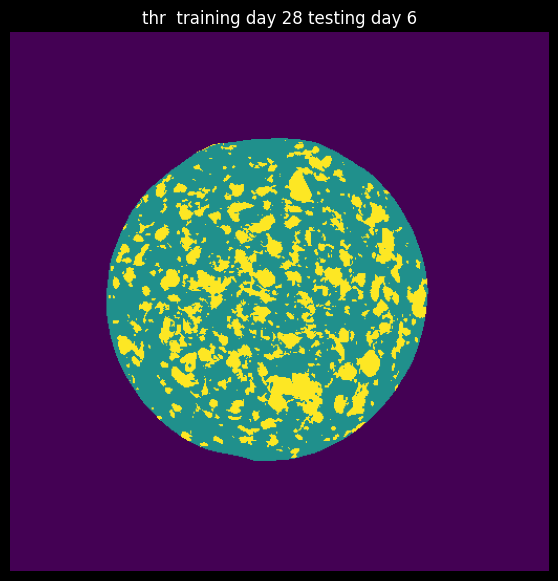

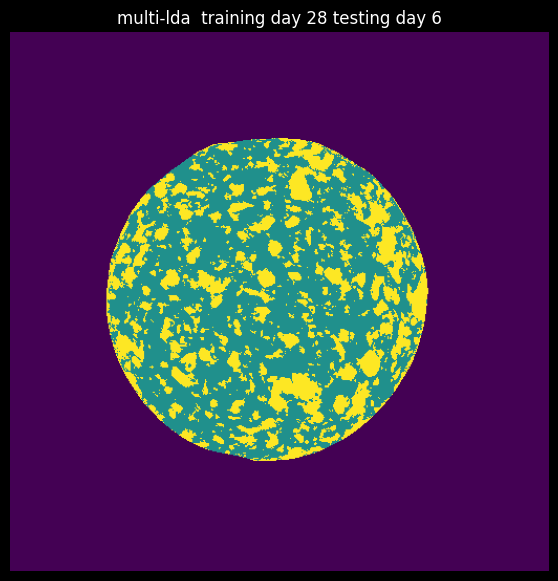

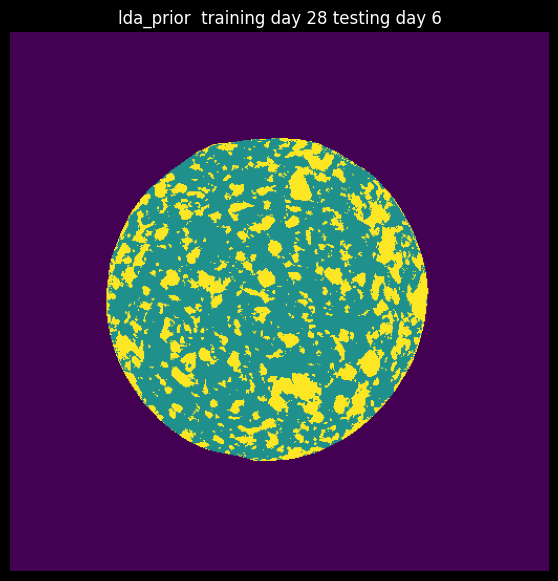

In [138]:
# plot classification for given training and test day
training_day = classifications[28]
test_day = training_day[6]
print(test_day["training_day"], test_day["testing_day"])
for model in ["thr", "multi-lda", "lda_prior"]:
    plt.figure(figsize=(7, 7))
    plt.imshow(test_day[model])
    plt.title(model + " " + " training day " + str(test_day["training_day"]) + " testing day " + str(test_day["testing_day"]))
    plt.axis("off")
    plt.show()
